# Policy Learning on the CartPole Environment

In this practice we will policy learning algorithms to the CartPole-v1 environment from the [OpenAI Gym](https://gym.openai.com/). In this environment, the task is to balance the pole that is attached to the cart, by moving the cart to either side. The reward gets incremented for each step (for up to 200 steps) where the pole is not exceeding a set angle and the cart is not touching the sides of the line.

![cartpole](https://github.com/pytorch/tutorials/blob/main/_static/img/cartpole.gif?raw=true)

The environment provides four parameters that represent the state of the environment:
Position and velocity of the cart and angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).

In this notebook, we will implement Q-learning for this environment. As you will notice, the state space of Cartpole uses continues values, hence we will need to discretize, in order to apply the tabular version of Q-Learning.


# Policy gradients

Policy gradients is a family of algorithms for solving reinforcement learning problems by directly optimizing the policy in policy space. This is in stark contrast to value based approaches (such as Q-learning used previous practices or in [Learning Atari games by DeepMind](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning). This practice implements the Vanilla Policy Gradient (VPG aka REINFORCE).

Policy gradients have several appealing properties, for one they produce stochastic policies (by learning a probability distribution over actions given observations) whereas value based approaches are deterministic as they will typically choose actions greedily with respect to the value function being learned which can lead to under-exploration (one needs to introduce exploration strategies such as $\epsilon$-greedy explicitly to get around this). Another advantage of policy gradients is their ability to tackle continuous action spaces without discretisation which is necessary for value based methods. 

One of the biggest disadvantages of policy gradients is their high variance estimates of the gradient updates. This leads to very noisy gradient estimates and can de-stabilize the learning process. Significant efforts in reinforcement learning research with policy gradients in the past few years has been about trying to reduce the variance of these gradient updates to improve the trainability of these algorithms.

# Let's start by creating the environment

In [1]:
!pip install --upgrade gym==0.26.2

import gym
import numpy as np
# additional imports for saving and loading a trained policy
from gym.wrappers.record_video import RecordVideo

print(gym.__version__)

env = gym.make('CartPole-v1')

0.26.2


As mentioned above the state space in this environment is composed of four continuous values corresponding to the
position and velocity of the cart, and the angle and angular velocity of the pole (see [the documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/#observation-space)).

Notice that in a real, physical environment the state of the cartpole problem would be much more complicated - it would include things like temperature, wind, friction between joints etc. In principle all of these could be measured and included in the observation vector, but it would be impossible to extract all the information about the state into an observation vector. In problems with partial observability (e.g. multiplayer games with imperfect information) the observations available to any one player are naturally a limited representation of the game state.

In [2]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In contrast, the action space is discrete and corresponds to the possible actions (left, right) 

In [3]:
env.action_space

Discrete(2)

Now that we know that the dimensions of the observation and action space we can design a policy that takes in observations and produces probabilities of actions. 

The parametrized policy $\pi_\theta$ can be any differentiable function where $\theta$ are the parameters. As seen in the lecture, for this problem we can use a plain logistic regression function to parametrize probabilities of moving left and right. Additionally, we can manually derive the gradients for the policy gradient update rule.

More complex problems can use a neural network where $\theta$ represents the learnable weights of the network. We will cover this case later in the course. 

**Observation:** There are different implementations of policy gradients on binary action space problems, some were using the Logistic Policy while others used [Softmax](https://en.wikipedia.org/wiki/Softmax_function). It turns out that Softmax applied to  a binary action space is not exactly equivalent to a Logistic policy - it has more parameters (8 for Softmax and 4 for Logistic in the cartpole example). More on this is shown below [B. Overparametrisation of Softmax](#appendix-b).

Let's write now a Python class that will act as our Logistic policy agent.

In [4]:
class LogisticPolicy:

    def __init__(self, θ, α, γ):
        # Initialize paramters θ, learning rate α and discount factor γ

        self.θ = θ
        self.α = α
        self.γ = γ

    def logistic(self, y):
        # definition of logistic function

        return 1/(1 + np.exp(-y))

    def probs(self, x):
        # returns probabilities of two actions
        if type(x) == np.ndarray:
            y = x @ self.θ
        else:
            y = x[0] @ (self.θ)

        
        prob0 = self.logistic(y)

        return np.array([prob0, 1-prob0])

    def act(self, x):
        # sample an action in proportion to probabilities

        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)

        return action, probs[action]

    def grad_log_p(self, x):
        # calculate grad-log-probs

        if type(x) == np.ndarray:
            y = x @ self.θ
        else:
            y = x[0] @ (self.θ)
        #print("x:", x, "Typ:", type(x), "Form:", getattr(x, "shape", "Kein Shape"))
        #print(self.logistic(y))
        
        if isinstance(x, tuple):
            x = x[0]
        grad_log_p0 = x - x*self.logistic(y)
        grad_log_p1 = - x*self.logistic(y)

        return grad_log_p0, grad_log_p1

    def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
        # dot grads with future rewards for each action in episode

        return grad_log_p.T @ discounted_rewards

    def discount_rewards(self, rewards):
        # calculate temporally adjusted, discounted rewards

        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        for i in reversed(range(0, len(rewards))):
            cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
            discounted_rewards[i] = cumulative_rewards

        return discounted_rewards

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        
        grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])
        
        assert grad_log_p.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = self.discount_rewards(rewards)

        # gradients times rewards
        dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

        # gradient ascent on parameters
        self.θ += self.α*dot

**Tangent:** during the writing of the temporally-adjusted discounted_rewards function I started thinking if one can optimize the for loop for better performance. For my attempts see [C. Efficient calculation of temporally adjusted discounted rewards](#appendix-c).

Let's also write a utility function that will run through one full episode and record all observations, actions taken and rewards received.

In [5]:
def run_episode(env, policy, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, prob = policy.act(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        done = truncated or terminated 

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)
    #print("rewards:", rewards)
    #print("observations:", observations)
    #print("actions:", actions)
    #print("probs:", probs)


    return totalreward, np.array(rewards), np.array(observations, dtype=object), np.array(actions), np.array(probs)

Finally, we write a training loop that will train an agent on the problem by repeated rollouts of a policy that is updated after the end of every episode:

In [6]:
def evaluate(θ, α, γ, Policy, seed=None):
    # initialize environment and policy
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    if seed is not None:
        env.reset(seed=seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    env = RecordVideo(env, './video_eval',  episode_trigger = lambda episode_number: True)
    env.reset()
    for _ in range(100):
        run_episode(env, policy, render=False)
    env.env.close()


def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):

    # initialize environment and policy
    env = gym.make('CartPole-v1', render_mode="rgb_array")
    if seed is not None:
        env.reset(seed=seed)
    episode_rewards = []
    policy = Policy(θ, α, γ)

    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)

        # keep track of episode rewards
        episode_rewards.append(total_reward)

        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)

    # evaluation call after training is finished - evaluate last trained policy on 100 episodes
    if evaluate:
        env = RecordVideo(env, './video_train',  episode_trigger = lambda episode_number: True)
        env.reset()
        for _ in range(100):
            run_episode(env, policy, render=False)
        env.env.close()

    return episode_rewards, policy

Now, let's run the training:

In [7]:
# for reproducibility
GLOBAL_SEED = 0
np.random.seed(GLOBAL_SEED)

evaluate(θ=np.random.rand(4),
  α=0.002,
  γ=0.99,
  Policy=LogisticPolicy,
  seed=GLOBAL_SEED)

episode_rewards, policy = train(θ=np.random.rand(4),
                                α=0.002,
                                γ=0.99,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=800,
                                seed=GLOBAL_SEED,
                                evaluate=False)


C:\Users\tjuva\anaconda3\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
C:\Users\tjuva\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-0.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-1.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-1.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-2.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-2.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-3.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-3.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-4.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-4.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-5.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-6.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-6.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-7.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-7.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-8.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-8.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-9.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-9.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-10.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-10.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-11.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-11.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-12.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-12.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-13.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-13.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-14.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-14.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-15.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-15.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-16.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-16.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-17.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-17.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-18.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-18.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-19.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-19.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-20.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-20.mp4


Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-21.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-21.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-22.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-22.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-23.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-23.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-24.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-24.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-25.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-25.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-26.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-26.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-27.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-27.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-28.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-28.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-29.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-29.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-30.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-30.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-31.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-31.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-32.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-32.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-33.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-33.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-34.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-34.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-35.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-35.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-36.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-36.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-37.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-37.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-38.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-38.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-39.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-39.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-40.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-40.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-41.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-41.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-42.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-42.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-43.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-43.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-44.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-44.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-45.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-45.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-46.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-46.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-47.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-47.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-48.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-48.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-49.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-49.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-50.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-50.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-51.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-51.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-52.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-52.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-53.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-53.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-54.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-54.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-55.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-55.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-56.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-56.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-57.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-57.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-58.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-58.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-59.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-59.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-60.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-60.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-61.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-61.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-62.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-62.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-63.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-63.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-64.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-64.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-65.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-65.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-66.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-66.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-67.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-67.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-68.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-68.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-69.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-69.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-70.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-70.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-71.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-71.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-72.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-72.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-73.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-73.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-74.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-74.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-75.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-75.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-76.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-76.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-77.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-77.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-78.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-78.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-79.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-79.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-80.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-80.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-81.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-81.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-82.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-82.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-83.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-83.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-84.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-84.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-85.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-85.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-86.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-86.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-87.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-87.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-88.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-88.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-89.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-89.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-90.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-90.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-91.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-91.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-92.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-92.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-93.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-93.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-94.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-94.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-95.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-95.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-96.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-96.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-97.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-97.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-98.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-98.mp4
Moviepy - Building video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-99.mp4.
Moviepy - Writing video C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\tjuva\git\Reinforcement Learning\RL_Labs\Lab4\video_eval\rl-video-episode-99.mp4


Let's inspect the results by plotting the reward against episode number during training:

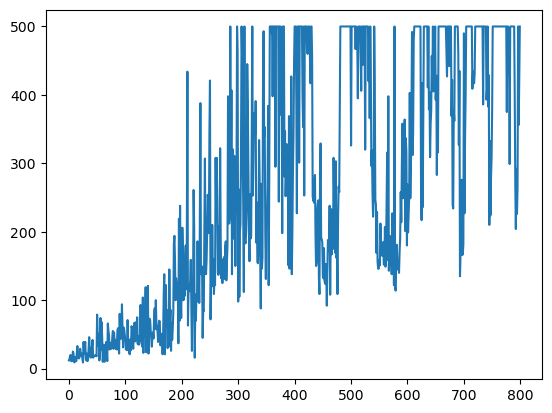

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

## Tasks

1. **Plotting** Write below the code to plot how many steps was the poilicy able to keep the pole balanced after training
2. **Learning** Is the agent able to learn a good policy? How stable is the performance?
3. **Training length** Would increasing the number of episodes to 1'200 lead to more stable performance?
4. **Stability per episode** Several approaches can be made to improve stability. For instance, we can increase the number of episodes per gradient update or introduce a learning rate scheduling
5. **Stability across episodes**Run the training 10 times with different random seeds and estimate the mean performance over time (with standard errors) 

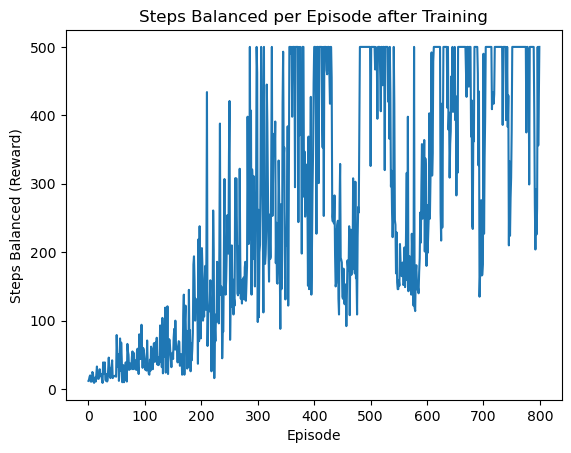

In [9]:
# Plot Results per episode
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Steps Balanced (Reward)")
plt.title("Steps Balanced per Episode after Training")
plt.show()

In [11]:
# Task 2/3
N = 50
average_reward = np.mean(episode_rewards[-N:])
print(f"Average reward over the last {N} episodes: {average_reward}")
print(f"Performance is {'stable' if average_reward >= 450 else 'unstable'} based on average reward.")


Average reward over the last 50 episodes: 458.28
Performance is stable based on average reward.


In [ ]:
#Task 4
We can change the learning rate!

In [ ]:
#Task 5

# Further reading

Additional material for those interested in diving deeper in the topic (these material will not be part of the exam)

Lilian Weng's [A (Long) Peek into RL](https://lilianweng.github.io/lil-log/2018/02/19/a-long-peek-into-reinforcement-learning.html) and [Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)

[Daniel Takeshi's derivations of policy gradients](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/)

[Sutton et. al. Policy Gradients in NIPS 1998](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf)

# APPENDICES - Advanced topics

# A. Overparametrisation of Softmax <a class="anchor" id="appendix-a"></a>

In logistic regression we use the parametrized logistic function $f_\theta(x)=\dfrac{e^{\theta\cdot x}}{1+e^{\theta\cdot x}}$ where $\theta, x$ are the $k$-dimensional weight and feature vectors respectively (we assume the bias term is incorporated within $\theta$ and $x$). Because there are only two classes, we interpret the value of $f_\theta(x)$ as $p(y=1\vert \theta,x)$, i.e. the probability of the first class. Then we get the probability of the second class for free since probabilities must sum to one.

The parametrized softmax function defined as $\sigma_\theta(x)_i=\dfrac{e^{\theta_i\cdot x}}{\sum_{j=1}^{m}e^{\theta_j\cdot x}}$ for $i=1,\dots,m$ is a generalization of the logistic function to $m$ output classes and extends logistic regression to multi-class problems. We interpret the value of $\sigma_\theta(x)_i$ as $p(y=i\vert \theta_i, x)$ for $i=1,\dots,m$. Note that with softmax there is a separate weight vector $\theta_i$ for each of the classes.

There is a subtle difference in going from the logistic function to the softmax function that is rarely explained but becomes apparent when you compare using the softmax function instead of the logistic function for a two-class problem. Essentially, the logistic function only maintains a parameter vector $\theta$ of length $k$ for estimating the first class probability while the softmax function maintains a separate parameter vector for each of the classes, thus in the two-class case a softmax formulation would have $2k$ parameters - twice as many as in logistic regression. This means that the softmax formulation results in redundant parameters - this is called overparametrization.

Let's write this out in detail. The class probabilities for an m-class problem are given by

$$
p(y=i\vert \theta_i,x) = \dfrac{e^{\theta_i\cdot x}}{\sum_{j=1}^{m}e^{\theta_j\cdot x}} \text{ ,for $i=1,\dots,m$}.  
$$

Let $\phi$ be some fixed vector and note that if we replace all $\theta_i$ by $\theta_i-\phi$, the probabilities are unchanged:

$$
\begin{aligned}
\dfrac{e^{(\theta_i-\phi)\cdot x}}{\sum_{j=1}^{m}e^{(\theta_j-\phi)\cdot x}} &= \\
&= \dfrac{e^{-\phi\cdot x}e^{\theta_i\cdot x}}{e^{-\phi\cdot x}\sum_{j=1}^{m}e^{\theta_j\cdot x}} \\
&= p(y=i\vert \theta_i,x).
\end{aligned}
$$

In particular, we can pick $\phi=\theta_0$ thus setting the first parameter vector to be identically zero in effect eliminating $k$ redundant parameters from calculations. Doing so in the $2$-class problem we would recover ordinary logistic regression with $k$ parameters, i.e. setting $\theta_0\to 0$ and $\theta_1\to\theta_1-\theta_0=:\theta$ would give $p_0=\dfrac{1}{1+e^{\theta\cdot x}}$ and $p_1=\dfrac{e^{\theta\cdot x}}{1+e^{\theta\cdot x}}$ as in vanilla logistic regression.

In our cartpole example because we used a vanilla logistic policy we ended up with four trainable weights, one for each of the observations. However, had we gone for a softmax policy with two classes we would have eight trainable weights instead.

In an $m$-class problem, the number of weights maintained by softmax is $m\times k$ but $k$ of these can be eliminated as shown. In practice, however, it is less hassle to keep the softmax formulation as is since enforcing some parameters to be zero would lead to less clean code and extra difficulties when calculating gradients.

For more discussion on the softmax function look [here](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/) and for more details concerning the overparametrization of softmax look [here](http://ufldl.stanford.edu/wiki/index.php/Softmax_Regression).

# B. Efficient calculation of temporally adjusted discounted rewards <a class="anchor" id="appendix-b"></a>

Looking at the training code, a potential inefficiency is in the function that calculates the discounted rewards for each step in an episode. Since it is a for loop in Python it is worth investigating whether it can be sped up by vectorizing.

First, let's time the original function with some random vectors of fixed size:

In [ ]:
def discount_rewards(rewards, gamma):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards
    return discounted_rewards

In [ ]:
%timeit discount_rewards(np.random.rand(100), 0.99)

## First attempt: vectorizing
The first thing when you see a for loop in numerical Python code is trying to see if you can vectorize it for performance. If we let $\mathbf{r,\hat{r}}$ be the vectors containing the original and discounted rewards respectively for each step in the episode then we can write the above for loop as a matrix equation $\mathbf{\hat{r}}=\mathbf{\Gamma r}$, where

$$
\mathbf{\Gamma} =  \begin{bmatrix}1 & \gamma & \gamma^2 & \cdots & \gamma^{n-1} \\
0 & 1 & \gamma & \cdots & \gamma^{n-2} \\
\vdots & & \ddots & \\
0 & 0 & \cdots & 1 & \gamma \\
0 & 0 & 0 & \cdots & 1
\end{bmatrix}.
$$

This type of matrix is known as a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix) (research hack: I did not know the name of this type of matrix but I thought it must have one given its special properties, so I typed in an example matrix into [Wolfram Alpha](https://www.wolframalpha.com/input/?i=%5B%5B1,a,a%5E2%5D,%5B0,1,a%5D,%5B0,0,1%5D%5D) which kindly provided me with a name). Scipy has a function ```scipy.linalg.toeplitz``` for constructing such matrices, so let's try to use it to rewrite our code like this:

In [ ]:
import scipy as sp
import scipy.linalg

def toeplitz_discount_rewards(rewards, gamma):
    n = len(rewards)
    c = np.zeros_like(rewards)
    c[0] = 1

    r = np.array([gamma**i for i in range(n)])
    matrix = sp.linalg.toeplitz(c, r)
    discounted_rewards = matrix @ rewards
    return discounted_rewards

And time this for comparison with the original:

In [ ]:
%timeit toeplitz_discount_rewards(np.random.rand(100), 0.99)

So in fact this is much worse than the original implementation. This is not a big surprise since there is a lot of overhead in building the matrix and then doing the matrix-vector calculation, so the single pass over the reward vector in the original loop seems pretty performant.

## Second attempt: OpenAI hack

While reading the source code of OpenAI's excellent RL learning library [spinning up](https://spinningup.openai.com/en/latest/) I came across [this curious implementation of discounted rewards](https://github.com/openai/spinningup/blob/fc75b23d539ad1f511e537df9abf21a7aa329706/spinup/algos/vpg/core.py#L45):

In [ ]:
import scipy.signal

def magic_discount_rewards(rewards, gamma):
    return sp.signal.lfilter([1], [1, float(-gamma)], rewards[::-1], axis=0)[::-1]

This is using the Scipy signal processing library, using a digital filter on a 1D data sequence ([see the docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html)).

Let's test it:

In [ ]:
%timeit magic_discount_rewards(np.random.rand(100), 0.99)

This is two to three times faster than the original implementation! Well worth using for problems where this calculation is frequent.